# <center> Lecture15 : Hierarchical Models </center>  
 
## <center> Instructor: Dr. Hu Chuan-Peng </center> 

## Intro

* 在lec14中，我们已经接触到了层级模型

* 在本节课中，我们将介绍引入包含自变量时的层级模型

* 我们使用的变量仍为介绍正态回归模型时所用的压力分数与自我控制分数

* 假设压力与自我控制之间的线性关系在不同的文化下是不同的，那么在分析时可以将数据的层级结构考虑在内

In [2]:
# 导入 pymc 模型包，和 arviz 等分析工具 
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import ipywidgets
import bambi as bmb

# 忽略不必要的警告
import warnings
warnings.filterwarnings("ignore")

In [18]:
# 通过 pd.read_csv 加载数据 Data_Sum_HPP_Multi_Site_Share.csv
# df_raw = pd.read_csv('/home/mw/input/bayes20238001/Data_Sum_HPP_Multi_Site_Share.csv')
df_raw = pd.read_csv('Data_Sum_HPP_Multi_Site_Share.csv')

first5_site = ['Southampton','Portugal','Kassel','Tsinghua','UCSB']
df_first5 = df_raw.query("Site in @first5_site")

df_first5["site_idx"] = pd.factorize(df_first5.Site)[0]

df_first5["obs_id"] = range(len(df_first5))

df_first5.set_index(['Site','obs_id'],inplace=True,drop=False)

len(df_first5)

415

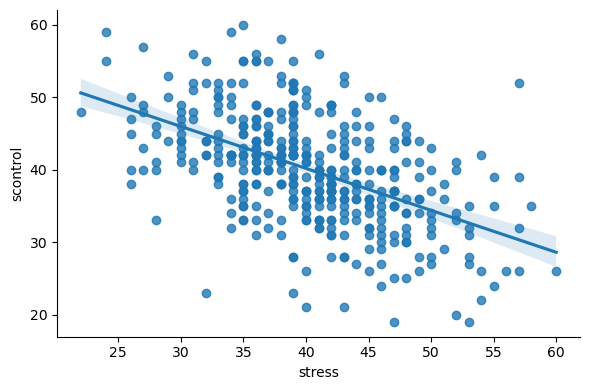

In [14]:
sns.lmplot(df_first5,
           x="stress",
           y="scontrol",
           height=4, aspect=1.5)

## Complete pooling

* 和上节课相同，如果我们忽略数据的层级结构，认为所有数据都来自一个更大的总体，只需要用一个回归方程来描述自变量与因变量的关系

* 该模型是我们熟悉的正态回归模型

$$  
\begin{array}{lcrl}  
\text{data:} & \hspace{.05in} &   Y_i | \beta_0, \beta_1, \sigma & \stackrel{ind}{\sim} N\left(\mu_i, \sigma^2\right) \;\; \text{ with } \;\; \mu_i = \beta_0 + \beta_1X_i \\  

\text{priors:} & & \beta_{0}  & \sim N\left(0, 50^2 \right)  \\  
                    & & \beta_1  & \sim N\left(0, 5^2 \right) \\  
                    & & \sigma   & \sim \text{Exp}(1)  \\  
\end{array}  
$$ 

### 模型定义

In [407]:
coords = {"obs_id": df_first5.obs_id}
with pm.Model(coords=coords) as complete_pooled_model:

    beta_0 = pm.Normal("beta_0", mu=0, sigma=50)                #定义beta_0          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=5)                 #定义beta_1
    sigma = pm.Exponential("sigma", 1)                          #定义sigma

    x = pm.MutableData("x", df_first5.stress, dims="obs_id")    #x是自变量压力水平

    mu = pm.Deterministic("mu",beta_0 + beta_1 * x, 
                          dims="obs_id")                        #定义mu，讲自变量与先验结合

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=df_first5.scontrol,
                           dims="obs_id")                       #定义似然：预测值y符合N(mu, sigma)分布
                                                                #通过 observed 传入实际数据y 自我控制水平
    complete_trace = pm.sample(random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 53 seconds.


### 后验参数估计：

结果显示：

$\mu_i = \beta_0 + \beta_1X_i $
- $\beta_0 = 63.17$
- $\beta_1 = -0.58$

In [208]:
az.summary(complete_trace,
           var_names=["~mu"],
           filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,63.173,1.940,59.583,66.899,0.049,0.034,1583.0,1389.0,1.0
beta_1,-0.575,0.048,-0.664,-0.485,0.001,0.001,1602.0,1437.0,1.0
sigma,6.471,0.220,6.078,6.906,0.005,0.004,1862.0,1782.0,1.0


### 后验预测回归线

* 在完全池化模型中，生成的后验预测回归线只有一条

In [415]:
#提取不同站点数据对应的索引并储存，便于后续将后验预测数据按照站点进行提取
def get_group_index(data):
    group_index = {}
    for i, group in enumerate(data["Site"].unique()):
        group_index[group] = xr.DataArray(data.query(f"Site == '{group}'"))["obs_id"].values
    return group_index

In [414]:
#定义函数，绘制不同站点下的后验预测回归线
def plot_regression(data, trace, group_index):
    # 定义画布，根据站点数量定义画布的列数
    fig, ax = plt.subplots(1,len(data["Site"].unique()), 
                       sharex=True,
                       sharey=True,
                       figsize=(15,5))
    
    # 根据站点数来分别绘图
    # 我们需要的数据有原始数据，每一个因变量的后验预测均值
    # 这些数据都储存在后验参数采样结果中，也就是这里所用的trace
    for i, group in enumerate(data["Site"].unique()):
        #绘制真实数据的散点图
        ax[i].scatter(trace.constant_data.x.sel(obs_id = group_index[f"{group}"]),
                trace.observed_data.y_est.sel(obs_id = group_index[f"{group}"]),
                color=f"C{i}",
                alpha=0.5)
        #绘制回归线
        ax[i].plot(trace.constant_data.x.sel(obs_id = group_index[f"{group}"]),
                trace.posterior.mu.sel(obs_id = group_index[f"{group}"]).stack(sample=("chain","draw")).mean(dim="sample"),
                color=f"C{i}",
                alpha=0.5)
        #绘制预测值95%HDI
        az.plot_hdi(
            trace.constant_data.x.sel(obs_id = group_index[f"{group}"]),
            trace.posterior.mu.sel(obs_id = group_index[f"{group}"]),
            hdi_prob=0.95,
            fill_kwargs={"alpha": 0.25, "linewidth": 0},
            color=f"C{i}",
            ax=ax[i])
    # 生成横坐标名称
    fig.text(0.5, 0, 'Stress', ha='center', va='center', fontsize=12)
    # 生成纵坐标名称
    fig.text(0.08, 0.5, 'Self control', ha='center', va='center', rotation='vertical', fontsize=12)
    # 生成标题
    plt.suptitle("Posterior regression models", fontsize=15)
        
    sns.despine()

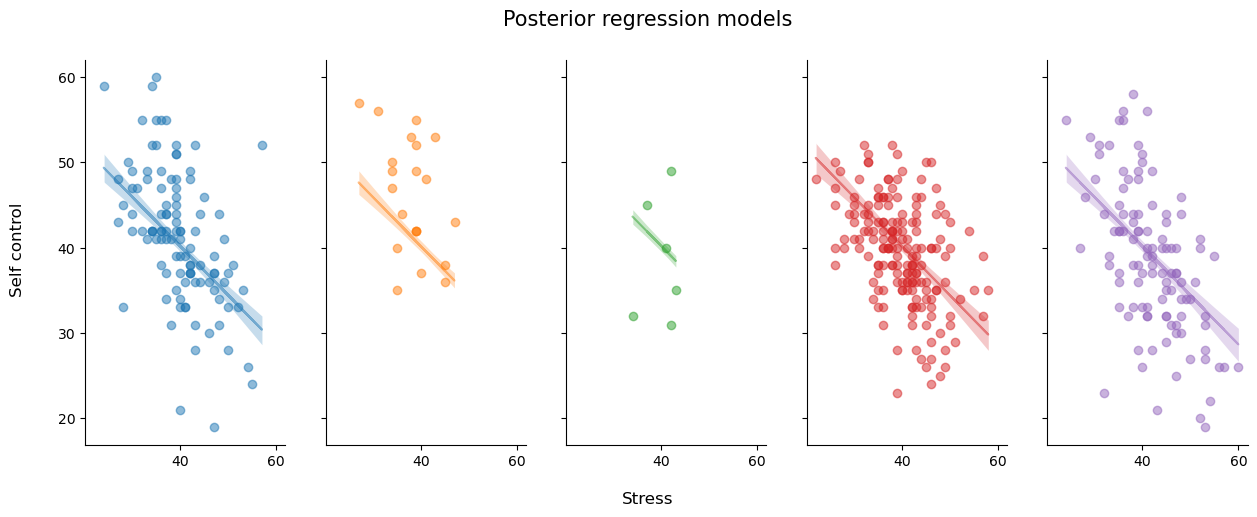

In [373]:
first5_index = get_group_index(data=df_first5)
plot_regression(data=df_first5,
                trace=complete_trace,
                group_index=first5_index)

## No pooling

* 同样地，接下来我们暂时忽略总体信息，只考虑分组信息

* 不同站点间，线性关系中的参数(斜率、截距)是相互独立的

* 我们使用$j$来表示不同的站点，$j\in(0,1,2,3,4,5)$，从分布中抽取不同站点的参数


$$  
\begin{array}{lcrl}  
\text{data:} & \hspace{.05in} &   Y_i | \beta_0j, \beta_1j, \sigma & \stackrel{ind}{\sim} N\left(\mu_i, \sigma^2\right) \;\; \text{ with } \;\; \mu_i = \beta_{0j} + \beta_{1j}X_i \\  

\text{priors:} & & \beta_{0j}  & \sim N\left(0, 50^2 \right)  \\  
                    & & \beta_{1j}  & \sim N\left(0, 5^2 \right) \\  
                    & & \sigma   & \sim \text{Exp}(1)  \\  
\end{array}  
$$ 

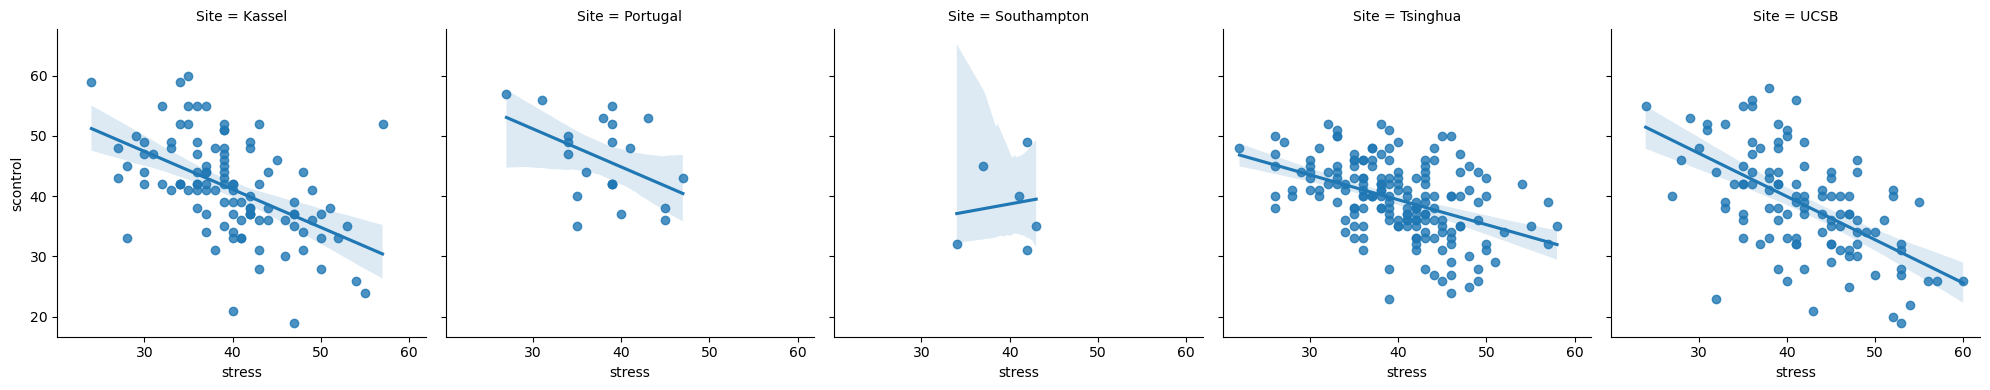

In [ ]:
# 创建画图所需的网格数
g = sns.FacetGrid(df_first5, col="Site", col_wrap=5, height=4)

# 将各个图所画的内容对应到画布上
g.map(sns.regplot, "stress", "scontrol")

# Show the plot
plt.show()

### 模型定义

In [215]:
coords = {"site": df_first5["Site"].unique(),
          "obs_id": df_first5.obs_id}

with pm.Model(coords=coords) as no_pooled_model:

    #定义截距、斜率，指定dims="site"，生成每个站点对应的截距、斜率
    beta_0 = pm.Normal("beta_0", mu=0, sigma=50, dims="site")
    beta_1 = pm.Normal("beta_1", mu=0, sigma=5, dims="site")    
    #定义sigma，指定dims="site"，生成不同的sigma
    sigma = pm.Exponential("sigma", 2, dims="site") 

    #传入自变量、获得观测值对应的站点映射
    site = pm.MutableData("site", df_first5.site_idx, dims="obs_id") 
    x = pm.MutableData("x", df_first5.stress, dims="obs_id")

    #线性关系
    mu = pm.Deterministic("mu", beta_0[site]+beta_1[site]*x, dims="obs_id")
    # 定义 likelihood
    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma[site], observed=df_first5.scontrol, dims="obs_id")

    no_trace = pm.sample(random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 331 seconds.


###  后验参数估计

* 可以看到每个站点的的截距(beta_0[xx])、斜率(beta_1[xx])，以及观测值所服从的正态分布中的标准差sigma[xx]都是不同的

In [216]:
az.summary(no_trace,
           var_names=["beta","sigma"],
           filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0[Kassel],65.964,3.864,58.686,73.164,0.032,0.023,14193.0,13243.0,1.0
beta_0[Portugal],67.550,9.320,50.048,85.391,0.087,0.062,11424.0,11466.0,1.0
beta_0[Southampton],23.139,21.353,-17.802,62.898,0.180,0.131,14111.0,13045.0,1.0
beta_0[Tsinghua],55.745,2.478,51.088,60.336,0.022,0.015,13240.0,13147.0,1.0
beta_0[UCSB],68.278,3.938,60.927,75.655,0.035,0.025,12353.0,12757.0,1.0
beta_1[Kassel],-0.621,0.096,-0.802,-0.442,0.001,0.001,14161.0,13147.0,1.0
beta_1[Portugal],-0.565,0.243,-1.022,-0.103,0.002,0.002,11453.0,11549.0,1.0
beta_1[Southampton],0.389,0.535,-0.609,1.413,0.005,0.003,14056.0,12984.0,1.0
beta_1[Tsinghua],-0.408,0.061,-0.524,-0.295,0.001,0.000,13457.0,13351.0,1.0
beta_1[UCSB],-0.709,0.093,-0.883,-0.536,0.001,0.001,12278.0,12914.0,1.0


### 后验预测回归线

* 在非池化模型中，生成了5条斜率与截距各不相同的回归线


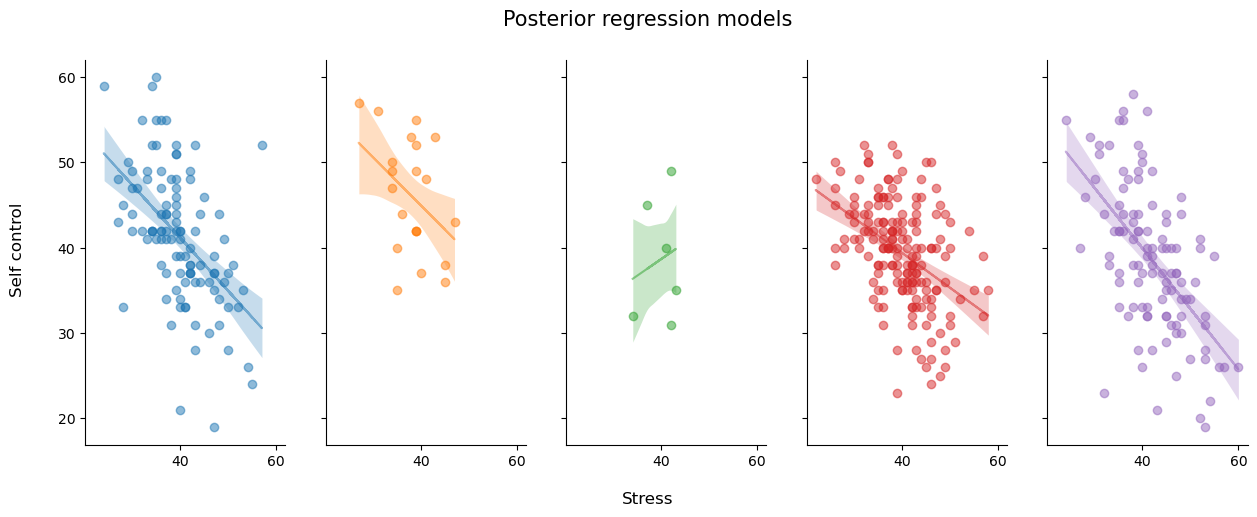

In [416]:
first5_index = get_group_index(data=df_first5)
plot_regression(data=df_first5,
                trace=no_trace,
                group_index=first5_index)

##  Hierarchical model with varying intercepts

### Layer 1: Variability within Site
**1. 自我控制与压力之间的关系在被试内有什么不同**

$$
Y_{ij} | \beta_{j}, \beta_1, \sigma_y \sim N(\mu_{ij}, \sigma_y^2) \;\; \text{ where } \; \mu_{ij} = \beta_{0j} + \beta_1 X_{ij}  .
$$

* 使用$i$表示每个站点内的第$i$个被试，$i \in (1,2,3...n)$
* 对于每一个被试来说，其自我控制分数服从以$\mu_{ij}$为均值，$\sigma_y$为标准差的正态分布

* 而$\mu_{ij}$由参数$\beta_{0j}$，$\beta_1$决定

    * 其中，$\beta_{0j}$在组与组之间不同(group-specific)

    * $\beta_1$和$\sigma_y$则是相同的(global)


### Layer 2: Variability between Site
**2. 自我控制与压力之间的线性关系在站点间有什么不同**

* 自我控制与压力之间的线性关系由截距和斜率两方面构成

* 我们认为在不同的站点之间，其截距是变化的

* 假设截距的基线(baseline)为$\beta_{0}$，不同站点间的组间差异为$\sigma_{0}$，则每个站点的截距可以表示为：

$$
\beta_{0j} | \beta_0, \sigma_0 \stackrel{ind}{\sim} N(\beta_0, \sigma_0^2)  .
$$

### Layer 3: Global priors
**3. 最后，我们对全局参数进行定义，即$\beta_{0}, \beta_1, \sigma_y, \sigma_0$**

$$
\begin{array}{rll}
\beta_{0}  & \sim N(m_0, s_0^2)  \\
\beta_1  & \sim N(m_1, s_1^2) & \\
\sigma_y & \sim \text{Exp}(l_y)    & \\
\sigma_0 & \sim \text{Exp}(l_0)    & \\
\end{array}

$$

**总结模型定义：**

$$
\begin{array}{rll}
Y_{ij} | \beta_{0j}, \beta_1, \sigma_y & \sim N(\mu_{ij}, \sigma_y^2) \;\; \text{ with } \;\;  \mu_{ij} = \beta_{0j} + \beta_1 X_{ij} & \text{(每个站点内的线性模型)} \\
\beta_{0j} | \beta_0, \sigma_0  & \stackrel{ind}{\sim} N(\beta_0, \sigma_0^2) & \text{(截距在站点间的变化)} \\
\beta_{0}  & \sim N(0, 50^2) & \text{(全局参数的先验)} \\
\beta_1  & \sim N(0, 5^2) & \\
\sigma_y & \sim \text{Exp}(1)    & \\
\sigma_0 & \sim \text{Exp}(1).    & \\
\end{array}
$$

### 另一种理解方式

* 我们可以把不同站点间截距的变化用另一种方式表达：

    * 不同站点间的截距是在$\beta_0$的基础上加上一些变化$b_{0j}$ 

    * 而$b_{0j}$ 则满足$b_{0j} \sim N(0, \sigma_0^2) $

$$\beta_{0j} = \beta_0 + b_{0j}$$
$$b_{0j} \sim N(0, \sigma_0^2)$$

* 整理一下则有：

$$
\begin{split}
Y_{ij} | \beta_{0j}, \beta_1, \sigma_y & \sim N(\mu_{ij}, \sigma_y^2) \;\; \text{ with } \;\;  \mu_{ij} = (\beta_0 + b_{0j}) + \beta_1 X_{ij}  \\
b_{0j} | \sigma_0  & \stackrel{ind}{\sim} N(0, \sigma_0^2)  \\
\beta_{0}  & \sim N(0, 50^2) \\
\beta_1  & \sim N(0, 1^2)  \\
\sigma_y & \sim \text{Exp}(1)  \\
\sigma_0 & \sim \text{Exp}(1).  \\
\end{split}
$$

### 模型定义

* 这里我们提供两种定义方式，并比较两种定义方式下MCMC采样结果的差异

In [362]:
non_centered = False
coords = {"site": df_first5["Site"].unique(),
          "obs_id": df_first5.obs_id}

with pm.Model(coords=coords) as var_inter_model:
    #定义全局参数
    beta_0 = pm.Normal("beta_0", mu=40, sigma=20)
    beta_0_sigma = pm.Exponential("beta_0_sigma", 1)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=5)
    sigma_y = pm.Exponential("sigma_y", 1) 

    #传入自变量、获得观测值对应的站点映射
    x = pm.MutableData("x", df_first5.stress, dims="obs_id")
    site = pm.MutableData("site", df_first5.site_idx, dims="obs_id") 
    
    #选择不同的模型定义方式
    if non_centered:
        beta_0_offset = pm.Normal("beta_0_offset", 0, sigma=1, dims="site")
        beta_0j = pm.Deterministic("beta_0j", beta_0 + beta_0_offset * beta_0_sigma, dims="site")
    else:
        beta_0j = pm.Normal("beta_0j", mu=beta_0, sigma=beta_0_sigma, dims="site")

    #线性关系
    mu = pm.Deterministic("mu", beta_0j[site]+beta_1*x, dims="obs_id")

    # 定义 likelihood
    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma_y, observed=df_first5.scontrol, dims="obs_id")

    var_inter_trace = pm.sample(draws=5000,            # 使用mcmc方法进行采样，draws为采样次数
                        tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                        chains=4,                     # 链数
                        discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                        random_seed=84735,
                        target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_0_sigma, beta_1, sigma_y, beta_0j]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 303 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.


In [363]:
non_centered = True
coords = {"site": df_first5["Site"].unique(),
          "obs_id": df_first5.obs_id}

with pm.Model(coords=coords) as var_inter_model:
    #定义全局参数
    beta_0 = pm.Normal("beta_0", mu=40, sigma=20)
    beta_0_sigma = pm.Exponential("beta_0_sigma", 1)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=5)
    sigma_y = pm.Exponential("sigma_y", 1) 
      

    #传入自变量、获得观测值对应的站点映射
    x = pm.MutableData("x", df_first5.stress, dims="obs_id")
    site = pm.MutableData("site", df_first5.site_idx, dims="obs_id") 

    if non_centered:
        beta_0_offset = pm.Normal("beta_0_offset", 0, sigma=1, dims="site")
        beta_0j = pm.Deterministic("beta_0j", beta_0 + beta_0_offset * beta_0_sigma, dims="site")

    else:
        beta_0j = pm.Normal("beta_0j", mu=beta_0, sigma=beta_0_sigma, dims="site")

    #线性关系
    mu = pm.Deterministic("mu", beta_0j[site]+beta_1*x, dims="obs_id")

    # 定义 likelihood
    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma_y, observed=df_first5.scontrol, dims="obs_id")

    var_inter_trace = pm.sample(draws=5000,            # 使用mcmc方法进行采样，draws为采样次数
                        tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                        chains=4,                     # 链数
                        discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                        random_seed=84735,
                        target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_0_sigma, beta_1, sigma_y, beta_0_offset]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 336 seconds.


### 先验预测检查

In [364]:
var_inter_prior = pm.sample_prior_predictive(samples=50,
                                            model=var_inter_model,
                                            random_seed=84735)

Sampling: [beta_0, beta_0_offset, beta_0_sigma, beta_1, sigma_y, y_est]


In [425]:
# 定义绘制先验预测回归线的函数，其逻辑与绘制后验预测回归线相同
def plot_prior(prior,group_index):
    # 定义画布，根据站点数量定义画布的列数
    fig, ax = plt.subplots(1,len(df_first5["Site"].unique()), 
                        sharex=True,
                        sharey=True,
                        figsize=(20,5))
    # 根据站点数来分别绘图
    # 我们需要的数据有原始数据中的自变量，每一个因变量的先验预测均值
    # 这些数据都储存在先验预测采样结果中，也就是这里所用的prior
    for i, group in enumerate(df_first5["Site"].unique()): 
        #绘制回归线
        ax[i].plot(prior.constant_data["x"].sel(obs_id = group_index[f"{group}"]),
                prior.prior["mu"].sel(obs_id = group_index[f"{group}"]).stack(sample=("chain","draw")),
                c='gray',
                alpha=0.5)
        ax[i].set_title(f"{group}")
    fig.text(0.5, 0, 'Stress', ha='center', va='center', fontsize=12)
    # 生成纵坐标名称
    fig.text(0.08, 0.5, 'Self control', ha='center', va='center', rotation='vertical', fontsize=12)
    # 生成标题
    plt.suptitle("Prior regression models", fontsize=15, y=1)
        
    sns.despine()

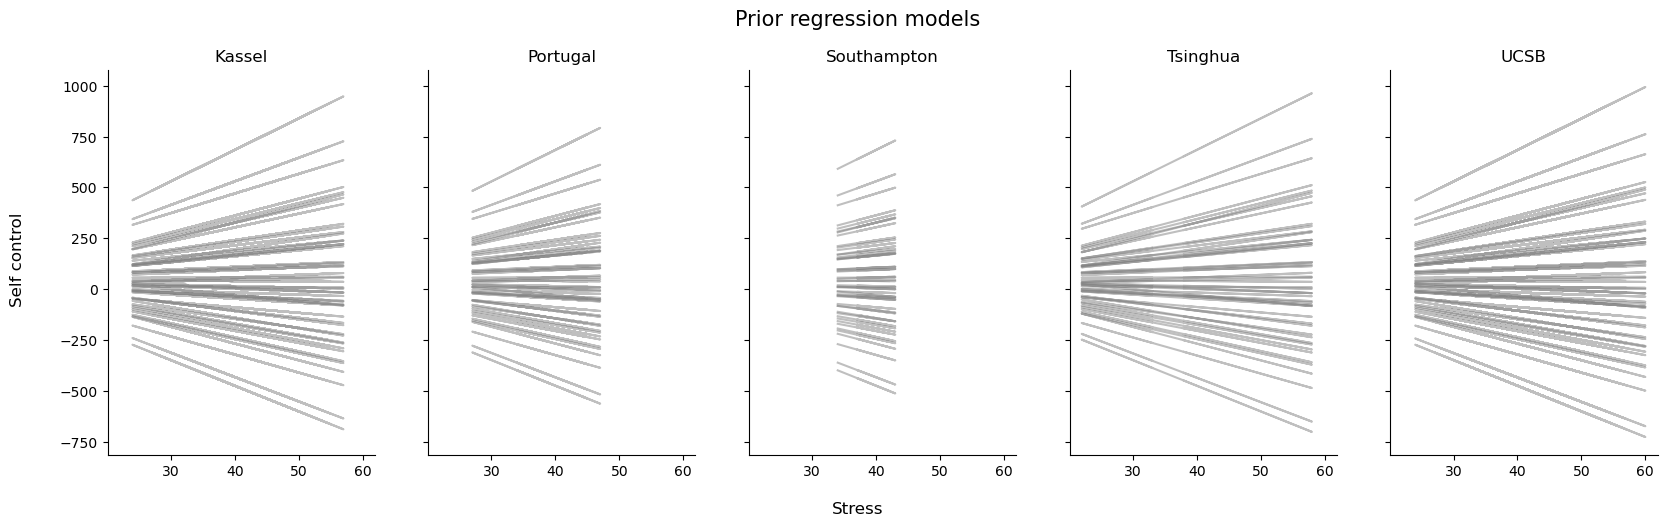

In [426]:
plot_prior(prior=var_inter_prior,
           group_index=first5_index)

###  MCMC采样&后验参数估计

* 可以看到5条回归线的斜率都是一致的$\beta_1 = -0.56$
* 但截距$\beta_{0j}[xx]$有所不同:
    * $\beta_{0}[Kassel] = 63.56$
    * $\beta_{0}[Portugal] = 65.37$
    * $\beta_{0}[Southampton] = 62.58$
    * $\beta_{0}[Tsinghua] = 62.09$
    * $\beta_{0}[UCSB] = 62.37$

In [399]:
# ~ 和filter_vars="like" 表示在显示结果时去除掉包含这些字符的变量
az.summary(var_inter_trace,
           var_names=["~mu","~_sigma"],
           filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,63.148,2.088,59.342,67.175,0.023,0.016,8390.0,11140.0,1.0
beta_1,-0.563,0.047,-0.651,-0.473,0.000,0.000,9881.0,12031.0,1.0
beta_0_offset[Kassel],0.319,0.653,-0.943,1.516,0.007,0.005,9474.0,11852.0,1.0
beta_0_offset[Portugal],1.381,0.797,-0.104,2.888,0.008,0.006,10364.0,9886.0,1.0
beta_0_offset[Southampton],-0.314,0.876,-1.961,1.330,0.007,0.006,16361.0,13762.0,1.0
beta_0_offset[Tsinghua],-0.743,0.648,-1.985,0.448,0.007,0.005,8960.0,11368.0,1.0
beta_0_offset[UCSB],-0.521,0.649,-1.728,0.691,0.007,0.005,9678.0,10635.0,1.0
sigma_y,6.383,0.221,5.968,6.792,0.002,0.001,16242.0,13722.0,1.0
beta_0j[Kassel],63.556,1.967,59.869,67.292,0.019,0.014,10461.0,12406.0,1.0
beta_0j[Portugal],65.369,2.303,61.083,69.659,0.023,0.017,9717.0,12261.0,1.0


### 后验预测回归线

* 5条回归线的截距不同，斜率相同

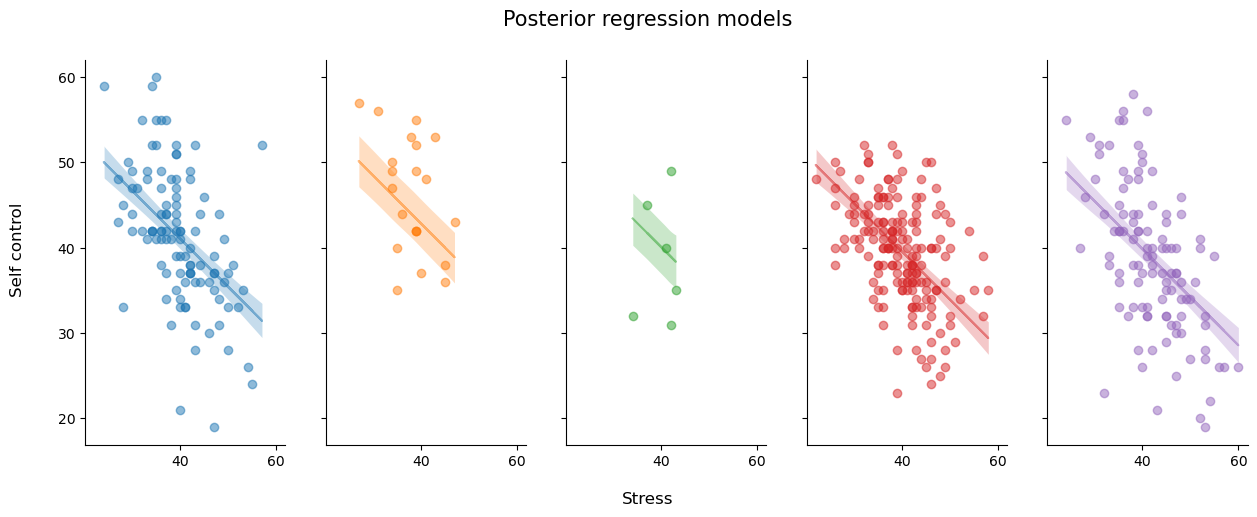

In [374]:
plot_regression(data=df_first5,
                trace=var_inter_trace,
                group_index=first5_index)

### 组间方差与组内方差

* 在这个模型定义中，组间方差来自`beta_0_offset`，组内方差来自`sigma_y`

In [388]:
# 提取组间和组内变异
para_sum = az.summary(var_inter_trace,
                      var_names=["_offset","sigma_"],
                      filter_vars="like")
between_sd = (para_sum.filter(like='_offset', axis=0)["mean"]**2).sum()
within_sd = para_sum.loc['sigma_y','mean']**2
# 计算变异占比
var = between_sd + within_sd
print("被组间方差所解释的部分：", between_sd/var)
print("被组内方差所解释的部分：", within_sd/var)
print("组内相关：",between_sd/var)


被组间方差所解释的部分： 0.06711151565666632
被组内方差所解释的部分： 0.9328884843433337
组内相关： 0.06711151565666632


## Hierarchical model with varying intercepts & slopes

* 在上一个模型中，组间差异只包含截距在不同站点间的差异

* 我们可以进一步考虑斜率在不同站点间的差异

$$

\beta_{0j} | \beta_0, \sigma_0 \sim N(\beta_0, \sigma_0^2)
\;\;\;\; \text{ and } \;\;\;\;
\beta_{1j} | \beta_1, \sigma_1 \sim N(\beta_1, \sigma_1^2)

$$

* 在非池化模型中，我们也认为斜率和截距在不同站点间是不同的；但在层级模型中，我们仍考虑了来自总体的的信息，即不同站点间的斜率/截距仍是从总体斜率/截距中抽样的。
$$

$$

$$

\beta_0 \sim N(0, 50)\\
\sigma_0 \sim \text{Exp}(1)\\
\beta_1 \sim N(0,5)\\
\sigma_1 \sim \text{Exp}(1)

$$

**总结模型定义：**

$$
\begin{array}{rll}
Y_{ij} | \beta_{0j}, \beta_1, \sigma_y & \sim N(\mu_{ij}, \sigma_y^2) \;\; \text{ with } \;\;  \mu_{ij} = \beta_{0j} + \beta_1 X_{ij} & \text{(每个站点内的线性模型)} \\
\beta_{0j} | \beta_0, \sigma_0  & \stackrel{ind}{\sim} N(\beta_0, \sigma_0^2) & \text{(截距在站点间的变化)} \\
\beta_{1j} | \beta_1, \sigma_1  & \stackrel{ind}{\sim} N(\beta_1, \sigma_1^2) & \text{(斜率在站点间的变化)} \\
\beta_{0}  & \sim N(0, 50^2) & \text{(全局参数的先验)} \\
\beta_1  & \sim N(0, 5^2) & \\
\sigma_y & \sim \text{Exp}(1)    & \\
\sigma_0 & \sim \text{Exp}(1).    & \\
\end{array}
$$

In [393]:
non_centered = True
coords = {"site": df_first5["Site"].unique(),
          "obs_id": df_first5.obs_id}

with pm.Model(coords=coords) as var_both_model:
    #定义全局参数
    beta_0 = pm.Normal("beta_0", mu=0, sigma=50)
    beta_0_sigma = pm.Exponential("beta_0_sigma", 1)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=5) 
    beta_1_sigma = pm.Exponential("beta_1_sigma", 1)
    sigma_y = pm.Exponential("sigma_y", 1) 

    #传入自变量、获得观测值对应的站点映射
    x = pm.MutableData("x", df_first5.stress, dims="obs_id")
    site = pm.MutableData("site", df_first5.site_idx, dims="obs_id") 

    #选择不同的模型定义方式
    if non_centered:
        beta_0_offset = pm.Normal("beta_0_offset", 0, sigma=1, dims="site")
        beta_0j = pm.Deterministic("beta_0j", beta_0 + beta_0_offset * beta_0_sigma, dims="site")
        beta_1_offset = pm.Normal("beta_1_offset", 0, sigma=1, dims="site")
        beta_1j = pm.Deterministic("beta_1j", beta_1 + beta_1_offset * beta_1_sigma, dims="site")
    else:
        beta_0j = pm.Normal("beta_0j", mu=beta_0, sigma=beta_0_sigma, dims="site")
        beta_1j = pm.Normal("beta_1j", mu=beta_1, sigma=beta_1_sigma, dims="site")

    #线性关系
    mu = pm.Deterministic("mu", beta_0j[site]+beta_1j[site]*x, dims="obs_id")

    # 定义 likelihood
    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma_y, observed=df_first5.scontrol, dims="obs_id")

In [390]:
var_both_prior = pm.sample_prior_predictive(samples=50,
                                            model=var_both_model,
                                            random_seed=84735)

Sampling: [beta_0, beta_0_offset, beta_0_sigma, beta_1, beta_1_offset, beta_1_sigma, sigma_y, y_est]


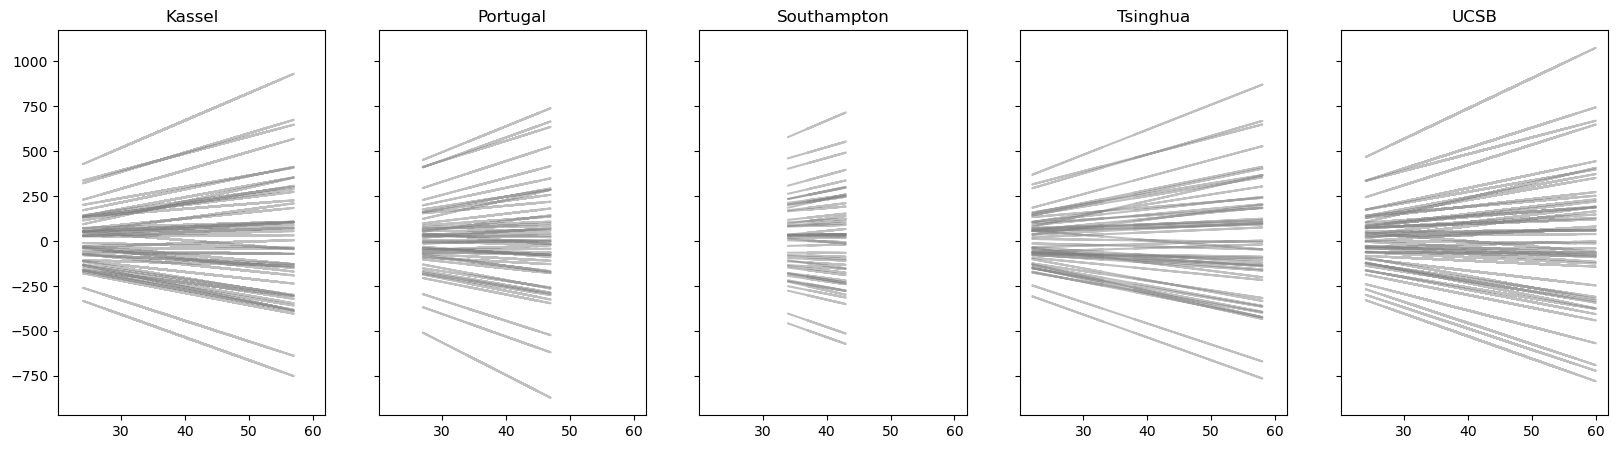

In [391]:
plot_prior(prior=var_both_prior, group_index=first5_index)

###  MCMC采样&后验参数估计

* 可以看到5条回归线的斜率$\beta_{1j}$、截距$\beta_{0j}$都是不同的
* $\beta_{1j}$、$\beta_{0j}$是在总体$\beta_{1}$、$\beta_{0}$上增加了一些变异

In [394]:
with var_both_model:
    var_both_trace = pm.sample(draws=5000,            # 使用mcmc方法进行采样，draws为采样次数
                        tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                        chains=4,                     # 链数
                        discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                        random_seed=84735,
                        target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_0_sigma, beta_1, beta_1_sigma, sigma_y, beta_0_offset, beta_1_offset]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 832 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [398]:
az.summary(var_both_trace,
           var_names=["j","beta_0","beta_1","~offset","~mu"],
           filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,62.872,2.125,58.751,66.738,0.018,0.013,14047.0,13165.0,1.0
beta_1,-0.552,0.063,-0.666,-0.430,0.001,0.000,10177.0,10408.0,1.0
beta_0_sigma,1.276,1.003,0.000,3.030,0.010,0.007,7828.0,9121.0,1.0
beta_1_sigma,0.070,0.062,0.000,0.166,0.001,0.001,5301.0,6332.0,1.0
sigma_y,6.364,0.221,5.960,6.787,0.001,0.001,23881.0,13620.0,1.0
beta_0j[Kassel],63.196,2.183,59.089,67.310,0.018,0.013,15240.0,14356.0,1.0
beta_0j[Portugal],63.834,2.614,58.942,68.823,0.025,0.018,10713.0,14140.0,1.0
beta_0j[Southampton],62.540,2.447,57.957,67.204,0.019,0.014,16504.0,14685.0,1.0
beta_0j[Tsinghua],61.805,2.181,57.840,66.005,0.017,0.012,16068.0,14420.0,1.0
beta_0j[UCSB],63.012,2.219,58.887,67.212,0.018,0.013,15577.0,14628.0,1.0


### 后验预测回归线
* 5条回归线的截距、斜率都是不同的

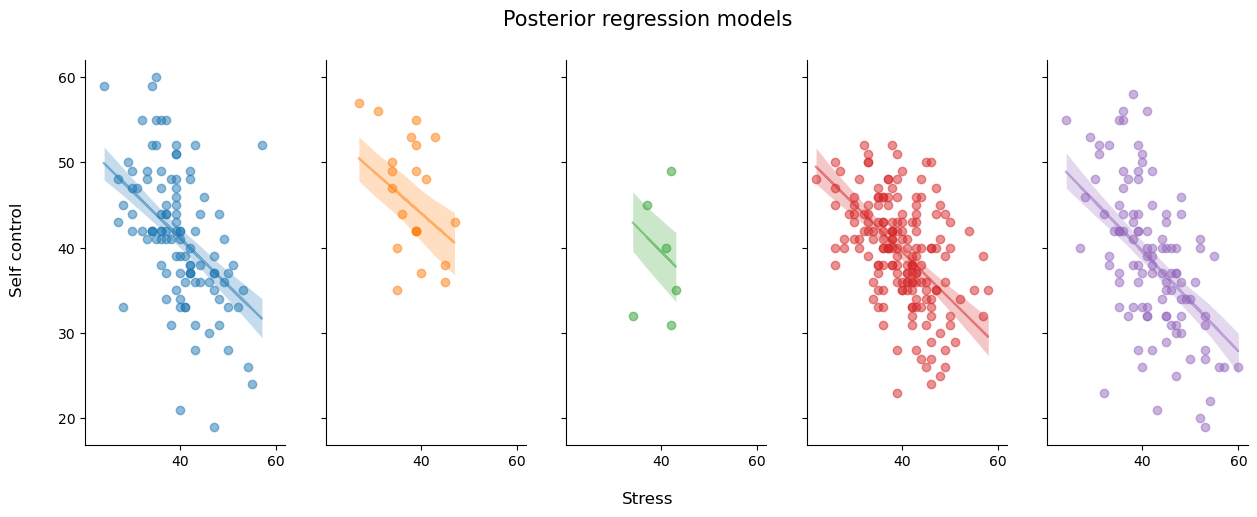

In [249]:
plot_regression(data=df_first5,
                trace=var_both_trace,
                group_index=first5_index)

### 组间方差与组内方差

* 在这个模型定义中，组间方差来自`beta_0_offset`、`beta_1_offset`，组内方差来自`sigma_y`

In [402]:
# 提取组间和组内变异
para_sum = az.summary(var_both_trace,
                      var_names=["_offset","sigma_"],
                      filter_vars="like")
between_sd = (para_sum.filter(like='_offset', axis=0)["mean"]**2).sum()
within_sd = para_sum.loc['sigma_y','mean']**2
# 计算变异占比
var = between_sd + within_sd
print("被组间方差所解释的部分：", between_sd/var)
print("被组内方差所解释的部分：", within_sd/var)
print("组内相关：",between_sd/var)


被组间方差所解释的部分： 0.04697400539307276
被组内方差所解释的部分： 0.9530259946069272
组内相关： 0.04697400539307276


## Model comparison

In [408]:
pm.compute_log_likelihood(complete_trace, model=complete_pooled_model)
pm.compute_log_likelihood(no_trace, model=no_pooled_model)
pm.compute_log_likelihood(var_inter_trace, model=var_inter_model)
pm.compute_log_likelihood(var_both_trace, model=var_both_model)

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [410]:
comparison_list = {
    "model1(complete pool)":complete_trace,
    "model2(no pool)":no_trace,
    "model3(hierarchy intercept)":var_inter_trace,
    "model4(hierarchy both)":var_both_trace,
}
az.compare(comparison_list)

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model4(hierarchy both),0,-1363.329645,7.546658,0.000000,0.327206,16.073491,0.000000,False,log
model3(hierarchy intercept),1,-1363.949401,6.770135,0.619755,0.000000,16.021236,0.899686,False,log
model2(no pool),2,-1365.795513,19.101172,2.465868,0.490499,17.895011,5.231309,False,log
model1(complete pool),3,-1368.041284,3.323460,4.711638,0.182295,15.926510,3.359162,False,log


## 预测来自新组的数据

* 我们可以根据当前的层级模型对新组别的数据进行预测，如"Zurich"站点

* 在pymc中，只要在`pm.sample_posterior_predictive`中传入模型MCMC后验参数采样结果，即可以在该模型的基础上对新数据生成预测

* 预测结果储存在`.predictions`中

In [411]:
# 选择站点为"Zurich"的数据
new_group = df_raw[df_raw.Site=="Zurich"]
# 生成被试索引
new_group["obs_id"] = range(len(new_group))
# 生成站点索引
new_group["site_idx"] = pd.factorize(new_group.Site)[0]

In [412]:
new_coords = {"site": new_group["Site"].unique(),
          "obs_id": new_group.obs_id}

with pm.Model(coords=new_coords) as hier_pred:
    #定义全局参数(这部分没有改变)
    beta_0 = pm.Normal("beta_0", mu=40, sigma=20)
    beta_0_sigma = pm.Exponential("beta_0_sigma", 1)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=5) 
    beta_1_sigma = pm.Exponential("beta_1_sigma", 1)
    sigma_y = pm.Exponential("sigma_y", 1) 

    #传入自变量
    x = pm.MutableData("x", new_group.stress, dims="obs_id")
    #获得观测值对应的站点映射
    site = pm.MutableData("site", new_group.site_idx, dims="obs_id") 
    
    #注意：在这里我们需要传入一个新的参数名，因为传入的是一个新站点(除此处外，其余的定义变量名未发生改变)
    new_beta_0_offset = pm.Normal("new_beta_0_offset", 0, sigma=1, dims="site")
    new_beta_0j = pm.Deterministic("new_beta_0j", beta_0 + beta_0_offset * beta_0_sigma, dims="site")
    new_beta_1_offset = pm.Normal("new_beta_1_offset", 0, sigma=1, dims="site")
    new_beta_1j = pm.Deterministic("new_beta_1j", beta_1 + beta_1_offset * beta_1_sigma, dims="site")
    new_mu = pm.Normal("new_mu",  new_beta_0j[site]+new_beta_1j[site]*x, dims="obs_id")

    #似然
    likelihood = pm.Normal("y_est", mu=new_mu, sigma=sigma_y, observed=new_group.scontrol, dims="obs_id")

    # 进行后验预测估计，注意使用的是上一个模型的后验参数估计，partial_trace
    pred_trace = pm.sample_posterior_predictive(var_both_trace,
                                                var_names=["new_mu","y_est"],
                                                predictions=True,
                                                extend_inferencedata=True,
                                                random_seed=84735)

Sampling: [new_mu, y_est]


In [413]:
pred_trace

Inference data with groups:
	> posterior
	> predictions
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

## bambi code

* bambi在对层级模型进行定义时，它认为组间参数如截距/斜率，由共同部分和组间变异组成(即pymc中的non-centered定义)

| 模型  | 模型表达    |
| -------- | ----------|
| complete_pool |"scontrol ~ stress" | 
| no pool | "scontrol ~ "scontrol ~ 0 + stress:Site"" |
| varing intercepts | scontrol ~ stress + (1|Site)| 
| varing slopes  |scontrol ~ stress + (0 + stress|Site) |
| varing intercepts and slopes  |"scontrol ~ 1 + stress + (stress|Site)"  |

* 1：在bambi中，1表示截距

* (stress|Site): 表示对于每个站点，其自变量压力的斜率由共同部分和斜率的组间变异组成，并且默认添加了共同截距和截距的组间变异

* (0 + stress|Site): 表示去除截距的组间变异

* (1|Site)：表示去除斜率的组间变异


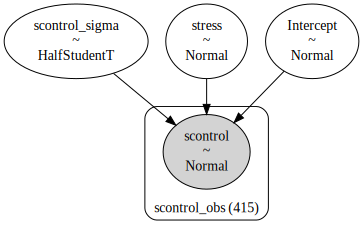

In [438]:
complete_bmb = bmb.Model("scontrol ~ stress",
                         df_first5,
                         family="gaussian")
complete_bmb.build()
complete_bmb.graph()

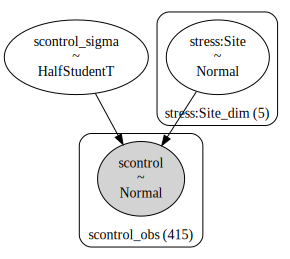

In [441]:
# no-pooled
no_bmb = bmb.Model("scontrol ~ 0 + stress:Site",
                      df_first5)
no_bmb.build()
no_bmb.graph()

In [443]:
no_trace = no_bmb.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [scontrol_sigma, stress:Site]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


In [444]:
az.summary(no_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
stress:Site[Kassel],0.997,0.029,0.944,1.052,0.000,0.000,4795.0,3219.0,1.0
stress:Site[Portugal],1.184,0.067,1.052,1.305,0.001,0.001,4735.0,3083.0,1.0
stress:Site[Southampton],0.964,0.121,0.739,1.193,0.002,0.001,5556.0,3233.0,1.0
stress:Site[Tsinghua],0.953,0.022,0.911,0.994,0.000,0.000,5383.0,3753.0,1.0
stress:Site[UCSB],0.875,0.027,0.825,0.928,0.000,0.000,6532.0,3015.0,1.0
scontrol_sigma,11.986,0.414,11.222,12.778,0.005,0.004,5782.0,3255.0,1.0


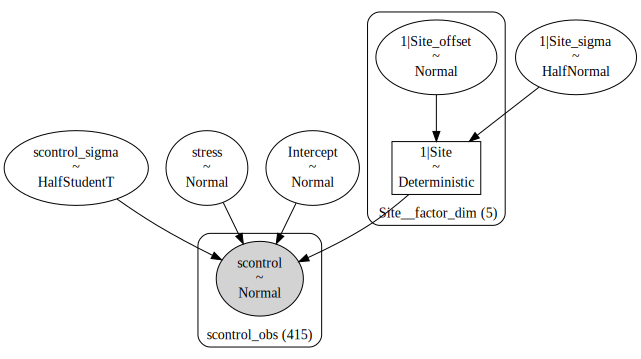

In [446]:
# group-specific intercepts
inter_bmb = bmb.Model("scontrol ~ stress + (1|Site)",
                      df_first5,
                      categorical="Site")

inter_bmb.build()
inter_bmb.graph()

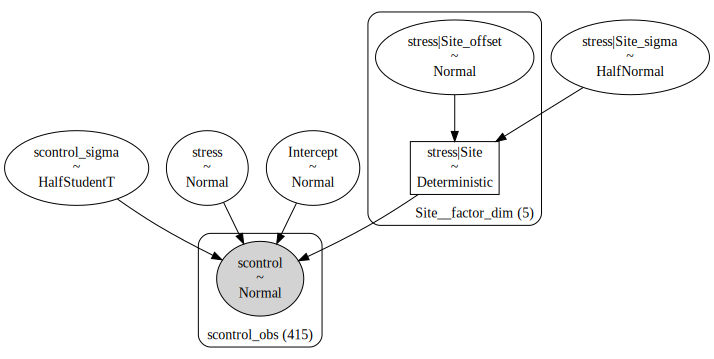

In [447]:
# group-specific slopes
slope_bmb = bmb.Model("scontrol ~ stress + (0 + stress|Site)",
                      df_first5,
                      categorical="Site")
slope_bmb.build()
slope_bmb.graph()

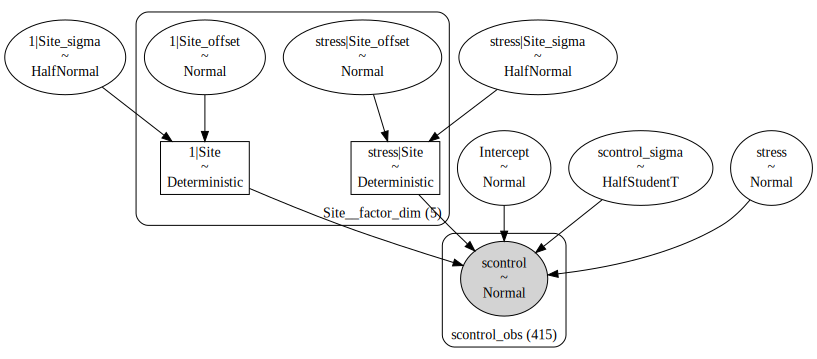

In [448]:
# group specific intercept and slope
var_both_bmb = bmb.Model("scontrol ~ 1 + stress + (stress|Site)",
                         df_first5,
                         categorical="Site")

var_both_bmb.build()
var_both_bmb.graph()


## Hierarchical logistic regression

* 在之前的课程中，除了正态回归模型，我们还介绍过logistic回归模型、泊松回归模型和负二项回归模型

* 这些模型同样可以和层级模型结合

* 例如，在lec13中我们使用回避依恋分数来预测个体的恋爱情况，假设这一线性关系在不同文化中有不同的表现，我们也可以把站点信息考虑在内

In [19]:
#查看所需列中是否存在缺失值
df_first5[df_first5[["romantic", "avoidance_r"]].isna().any(axis=1)]

age   anxiety  anxiety_r  artgluctot  attachhome  \
Site     obs_id                                                     
Kassel   103     NaN  3.166667   0.039748         0.0    4.888889   
         104     NaN  0.000000  -2.658639         NaN    4.333333   
         105     NaN  0.000000  -2.658639         NaN    3.888889   
Portugal 123     NaN  0.000000  -1.835996         NaN    5.000000   
         124     NaN  3.388889   0.631906         1.0    5.000000   
         125     NaN  0.000000  -1.835996         NaN    3.555556   
         126     NaN  0.000000  -1.835996         0.0    3.777778   
UCSB     408     NaN  3.611111   0.143634         0.0    4.777778   

                 attachphone  AvgHumidity    avgtemp  avoidance  avoidance_r  \
Site     obs_id                                                                
Kassel   103        4.111111          NaN  35.810000   3.055556     0.249759   
         104        3.000000          NaN  36.100000   3.055556     0.249759   
         105        1.777778          NaN  36.300000   2.111111    -0.811715   
Portugal 123        3.000000          NaN  36.200000   3.055556    -0.178491   
         124        3.666667          NaN  36.400000   4.000000     0.901529   
         125        3.000000         74.0  37.000000   3.166667    -0.051430   
         126        3.000000          NaN  37.100000   2.111111    -1.258510   
UCSB     408        3.000000         82.0  35.777778   3.055556    -0.160921   

                 ...  sex      Site  smoke  socialdiversity  socialembedded  \
Site     obs_id  ...                                                          
Kassel   103     ...  NaN    Kassel    NaN                6               4   
         104     ...  NaN    Kassel    NaN                3               1   
         105     ...  NaN    Kassel    NaN                0               1   
Portugal 123     ...  NaN  Portugal    NaN                0               1   
         124     ...  NaN  Portugal    NaN                8               3   
         125     ...  NaN  Portugal    NaN               11               5   
         126     ...  NaN  Portugal    NaN                0               1   
UCSB     408     ...  NaN      UCSB    NaN                6               5   

                 socTherm  soliTherm  stress  site_idx  obs_id  
Site     obs_id                                                 
Kassel   103          1.6      3.875      37         0     103  
         104          3.2      3.500      42         0     104  
         105          3.4      3.000      39         0     105  
Portugal 123          3.6      3.875      39         1     123  
         124          3.2      4.000      45         1     124  
         125          3.2      3.500      39         1     125  
         126          4.0      4.250      39         1     126  
UCSB     408          3.8      2.875      47         4     408  

[8 rows x 39 columns]

In [20]:
#删除缺失值
df_first5.dropna(subset=["romantic", "avoidance_r"], inplace=True)
#再次查看所需列中是否存在缺失值
df_first5[df_first5["romantic"].isna()]

,,age,anxiety,anxiety_r,artgluctot,attachhome,attachphone,AvgHumidity,avgtemp,avoidance,avoidance_r,...,sex,Site,smoke,socialdiversity,socialembedded,socTherm,soliTherm,stress,site_idx,obs_id
Site,obs_id,,,,,,,,,,,,,,,,,,,,,


In [22]:
#对数据进行重新编码
df_first5["romantic"] =  np.where(df_first5['romantic'] == 2, 0, 1)

In [23]:
len(df_first5)

407

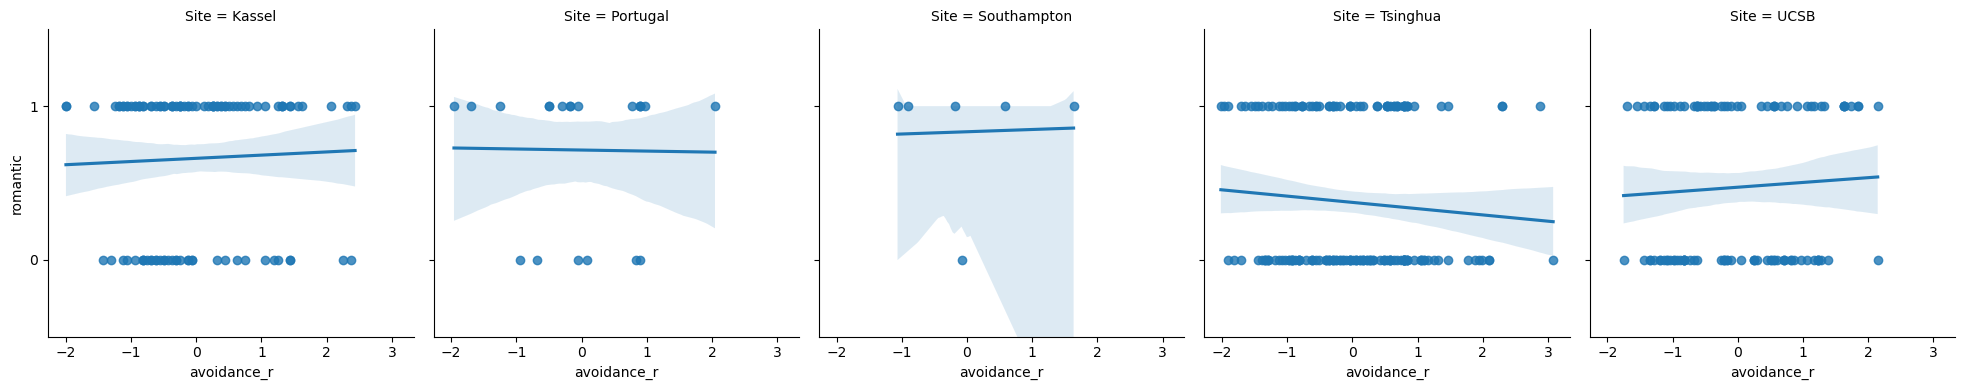

In [6]:
# 创建画图所需的网格数
g = sns.FacetGrid(df_first5, col="Site", col_wrap=5, height=4)

# 将各个图所画的内容对应到画布上
g.map(sns.regplot, "avoidance_r", "romantic")

# 调整y轴的刻度
plt.ylim(-0.5,1.5)
plt.yticks([0,1])
# Show the plot
plt.show()

### 完全池化模型

在这里，对完全池化模型的定义，和我们在lec13中介绍过的logistic回归模型是一样的

对先前介绍过的模型定义进行回顾：

* 因变量恋爱情况为二分变量

$$
Y_{ij} = \begin{cases}
1 & \text{yes} \\
0 & \text{no} \\
\end{cases}
$$

* 恋爱情况与回避依恋分数的情况可以表示为：

\begin{split}
Y_{ij}|\beta_0,\beta_1 & \stackrel{ind}{\sim} \text{Bern}(\pi_{ij}) \;\; \text{ with } \;\; \pi_i = \frac{e^{\beta_0 + \beta_1 X_{ij}}}{1 + e^{\beta_0 + \beta_1 X_{ij}}}  \\
\beta_{0}  &  \sim N\left(0, 0.5^2 \right)  \\
\beta_1  &  \sim N\left(0, 0.5^2 \right)   \\
\end{split}

#### 模型定义&MCMC采样

In [25]:
complete_logit_bmb = bmb.Model("romantic ~ avoidance_r", 
                               df_first5, 
                               family="bernoulli")
complete_logit_trace = complete_logit_bmb.fit(random_seed=84735)

Modeling the probability that romantic==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, avoidance_r]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


In [31]:
az.summary(complete_logit_trace)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

#### 变化截距模型

* 考虑线性关系(截距)在不同站点间的不同

$$
\begin{array}{rll}
Y_{ij}|\beta_{0j},\beta_{1j} & \sim \text{Bern}(\pi_{ij})\; \text{ with } \;\; \pi_i = \frac{e^{\beta_{0j} + \beta_{1} X_{ij}}}{1 + e^{\beta_{0j} + \beta_{1} X_{ij}}} \\ 
&& \text{(每个站点 $j$内的线性模型)}\\

\beta_{0j} &= \beta_0 + b_{0j}\;\;\;b_{0j} \sim N(0, \sigma_0^2)& \text{(截距在站点间的变化)} \\

\beta_{0}  &  \sim N\left(0, 0.5^2 \right) & \text{(全局参数的先验)}\\
\beta_1  &  \sim N\left(0, 0.5^2 \right) & \\
\sigma_0 & \sim \text{Exp}(1) & \\
\end{array}

$$

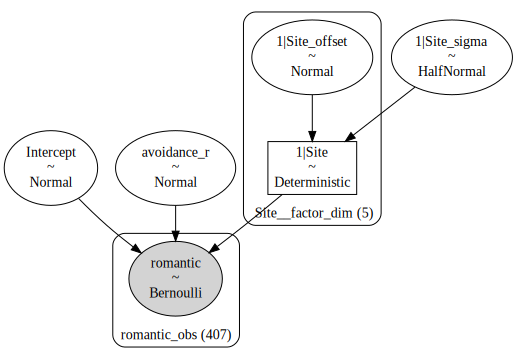

In [ ]:
# common slope/ common intercept + group-specific intercept
inter_logit_bmb = bmb.Model("romantic ~ avoidance_r + (1|Site)",
                               df_first5,
                               family="bernoulli")
inter_logit_bmb.build()
inter_logit_bmb.graph()

In [ ]:
both_logit_trace = both_logit_bmb.fit(draws=5000,           
                                    tune=1000,                    
                                    chains=4,                     
                                    discard_tuned_samples= True,  
                                    random_seed=84735,
                                    target_accept=0.99)

### 变化斜率模型

* 考虑线性关系(斜率)在不同站点间的不同

$$
\begin{array}{rll}
Y_{ij}|\beta_{0j},\beta_{1j} & \sim \text{Bern}(\pi_{ij})\; \text{ with } \;\; \pi_i = \frac{e^{\beta_{0} + \beta_{1j} X_{ij}}}{1 + e^{\beta_{0} + \beta_{1j} X_{ij}}} \\ 
&& \text{(每个站点 $j$内的线性模型)}\\
\beta_{1j} &= \beta_1 + b_{1j}\;\;\;b_{1j} \sim N(0, \sigma_1^2)& \text{(斜率在站点间的变化)} \\

\beta_{0}  &  \sim N\left(0, 0.5^2 \right) & \text{(全局参数的先验)}\\
\beta_1  &  \sim N\left(0, 0.5^2 \right) & \\
\sigma_1 & \sim \text{Exp}(1) & \\
\end{array}

$$

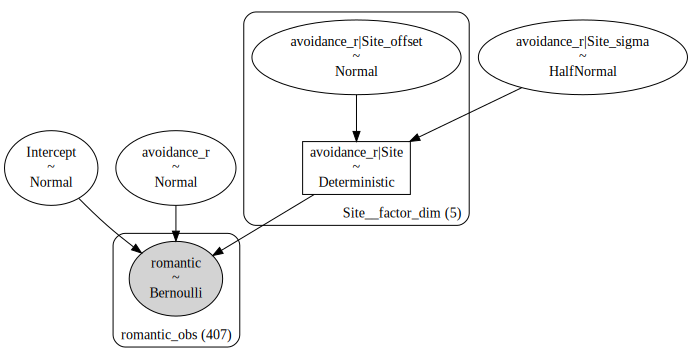

In [65]:
# common slope +group-specific slope/ common intercept + group-specific intercept
slope_logit_bmb = bmb.Model("romantic ~ avoidance_r + (0 + avoidance_r|Site)",
                               df_first5,
                               family="bernoulli")
slope_logit_bmb.build()
slope_logit_bmb.graph()

In [ ]:
both_logit_trace = both_logit_bmb.fit(draws=5000,           
                                    tune=1000,                    
                                    chains=4,                     
                                    discard_tuned_samples= True,  
                                    random_seed=84735,
                                    target_accept=0.99)

### 变化斜率、截距模型

* 考虑线性关系在不同站点间的不同

$$
\begin{array}{rll}
Y_{ij}|\beta_{0j},\beta_{1j} & \sim \text{Bern}(\pi_{ij})\; \text{ with } \;\; \pi_i = \frac{e^{\beta_{0j} + \beta_{1j} X_{ij}}}{1 + e^{\beta_{0j} + \beta_{1j} X_{ij}}} \\ 
&& \text{(每个站点 $j$内的线性模型)}\\

\beta_{0j} &= \beta_0 + b_{0j}\;\;\;b_{0j} \sim N(0, \sigma_0^2)& \text{(截距在站点间的变化)} \\

\beta_{1j} &= \beta_1 + b_{1j}\;\;\;b_{1j} \sim N(0, \sigma_1^2)& \text{(斜率在站点间的变化)} \\

\beta_{0}  &  \sim N\left(0, 0.5^2 \right) & \text{(全局参数的先验)}\\
\beta_1  &  \sim N\left(0, 0.5^2 \right) & \\
\sigma_0 & \sim \text{Exp}(1) & \\
\sigma_1 & \sim \text{Exp}(1) & \\
\end{array}

$$

#### 模型定义

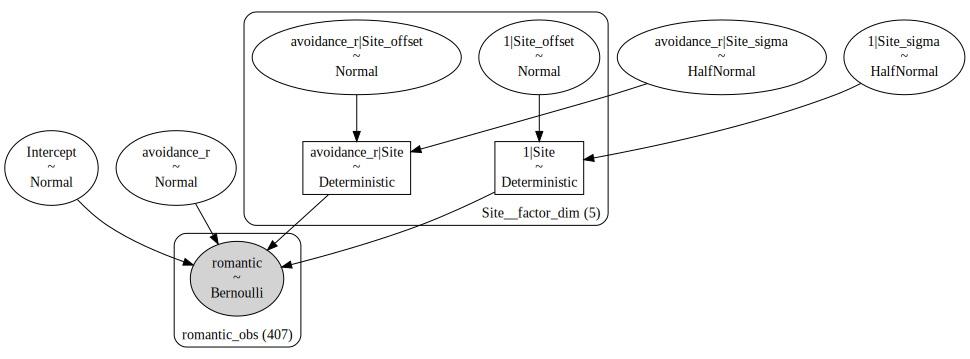

In [29]:
# common slope +group-specific slope/ common intercept + group-specific intercept
both_logit_bmb = bmb.Model("romantic ~ avoidance_r + (avoidance_r|Site)",
                               df_first5,
                               family="bernoulli")
both_logit_bmb.build()
both_logit_bmb.graph()

#### MCMC采样&后验参数解释

In [58]:
both_logit_trace = both_logit_bmb.fit(draws=5000,           
                                    tune=1000,                    
                                    chains=4,                     
                                    discard_tuned_samples= True,  
                                    random_seed=84735,
                                    target_accept=0.99)

Modeling the probability that romantic==1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, avoidance_r, 1|Site_sigma, 1|Site_offset, avoidance_r|Site_sigma, avoidance_r|Site_offset]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 558 seconds.


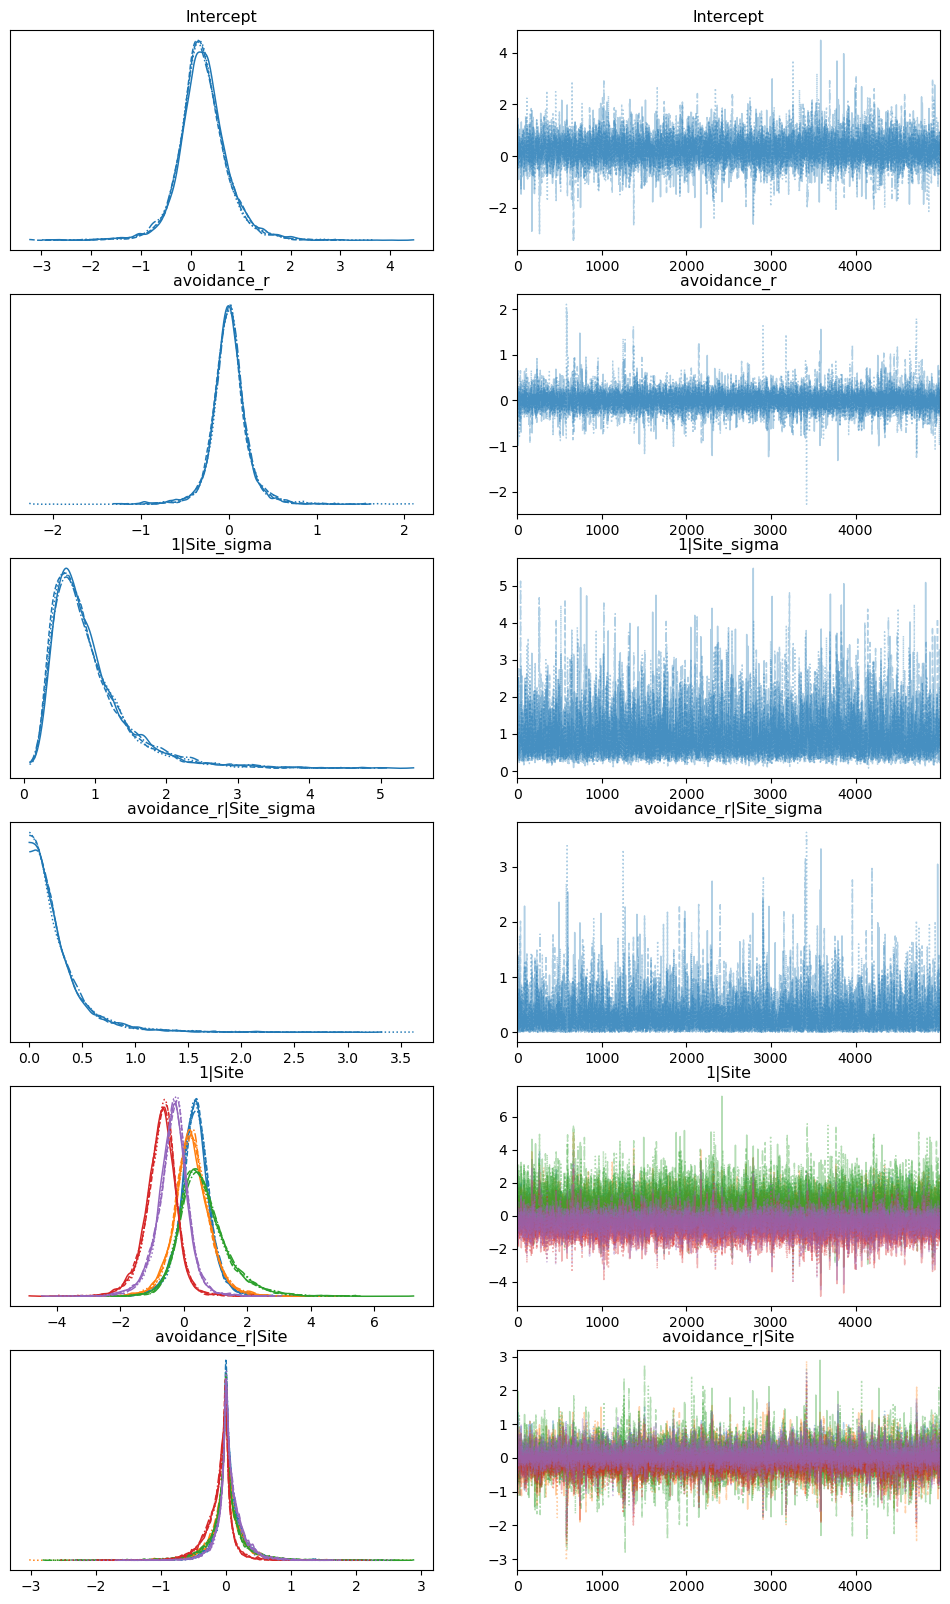

In [59]:
az.plot_trace(both_logit_trace,
              figsize=(12, 20))
plt.show()

#### 后验预测

In [60]:
both_logit_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [61]:
both_logit_bmb.predict(both_logit_trace)

In [62]:
both_logit_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

### 预测新站点的数据

In [63]:
# 选择站点为"Zurich"的数据
new_group = df_raw[df_raw.Site=="Zurich"]
# 生成被试索引
new_group["obs_id"] = range(len(new_group))
# 生成站点索引
new_group["site_idx"] = pd.factorize(new_group.Site)[0]
# 删除缺失值
new_group.dropna(subset=["romantic", "avoidance_r"], inplace=True)
new_group[new_group["romantic"].isna()]
# 对数据进行重新编码
new_group["romantic"] =  np.where(new_group['romantic'] == 2, 0, 1)

In [64]:
both_logit_bmb.predict(both_logit_trace,
                       kind="mean",
                       data=new_group,
                       sample_new_groups=True,
                       inplace=False)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

##

### 其他层级模型

#### varing intercept

In [8]:
non_centered = True
coords = {"site": df_first5["Site"].unique(),
          "obs_id": df_first5.obs_id}
with pm.Model(coords=coords) as hier_log:
    #传入自变量与因变量
    x = pm.MutableData("x", df_first5.avoidance_r, dims="obs_id")
    y = pm.MutableData('y', df_first5.romantic, dims = 'obs_id')

    #定义全局参数
    beta_0 = pm.Normal("beta_0", mu=0, sigma=0.5)          #定义beta_0
    beta_0_sigma = pm.Exponential("beta_0_sigma", 1)          
    beta_1 = pm.Normal("beta_1", mu=0, sigma=0.5)          #定义beta_1
    beta_1_sigma = pm.Exponential("beta_1_sigma", 1)

    #获得观测值对应的站点映射
    site = pm.MutableData("site", df_first5.site_idx, dims="obs_id") 

    #选择不同的模型定义方式，定义截距、斜率
    if non_centered:
        beta_0_offset = pm.Normal("beta_0_offset", 0, sigma=1, dims="site")
        beta_0j = pm.Deterministic("beta_0j", beta_0 + beta_0_offset * beta_0_sigma, dims="site")
        beta_1_offset = pm.Normal("beta_1_offset", 0, sigma=1, dims="site")
        beta_1j = pm.Deterministic("beta_1j", beta_1 + beta_1_offset * beta_1_sigma, dims="site")
    else:
        beta_0j = pm.Normal("beta_0j", mu=beta_0, sigma=beta_0_sigma, dims="site")
        beta_1j = pm.Normal("beta_1j", mu=beta_1, sigma=beta_1_sigma, dims="site")

    #线性关系
    mu = pm.Deterministic("mu", beta_0j[site] + beta_1j[site] * x, dims="obs_id")
    #进行logit变换
    pi = pm.Deterministic("pi", pm.math.invlogit(mu), dims="obs_id")
    #似然
    likelihood = pm.Bernoulli("y_est",p=pi, observed=y,dims="obs_id")

    hier_log_trace = pm.sample(draws=5000,            # 使用mcmc方法进行采样，draws为采样次数
                        tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                        chains=4,                     # 链数
                        discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                        random_seed=84735,
                        target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_0_sigma, beta_1, beta_1_sigma, beta_0_offset, beta_1_offset]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 264 seconds.


#### 绘制后验预测回归线

In [ ]:
#获得新数据集的索引
logit_index = get_group_index(data=df_first5)

In [ ]:
#绘图逻辑与上一个函数一样，只是此处使用logistic回归，绘制的变量需要更改
def plot_logit_regression(data,trace,group_index):
    # 定义画布，根据站点数量定义画布的列数
    fig, ax = plt.subplots(1,len(data["Site"].unique()), 
                        sharex=True,
                        sharey=True,
                        figsize=(15,5))
    
    # 根据站点数来分别绘图
    # 我们需要的数据有原始数据，每一个因变量的后验预测均值
    # 这些数据都储存在后验参数采样结果中，也就是这里所用的trace
    for i, group in enumerate(data["Site"].unique()):
        x = trace.constant_data.x.sel(obs_id = group_index[f"{group}"])
        #画出每个自变量对应的恋爱概率94%hdi值
        az.plot_hdi(
            x,
            trace.posterior.pi.sel(obs_id = group_index[f"{group}"]),
            hdi_prob=0.95,
            fill_kwargs={"alpha": 0.25, "linewidth": 0},
            color=f"C{i}",
            ax=ax[i])
        
        #得到每个自变量对应的恋爱概率均值，并使用sns.lineplot连成一条光滑的曲线
        post_mean = trace.posterior.pi.sel(obs_id = group_index[f"{group}"]).mean(("chain", "draw"))
        sns.lineplot(x = x, 
                    y= post_mean, 
                    color=f"C{i}",
                    ax=ax[i])
        ax[i].set_xlabel("")
        ax[i].set_ylabel("")
        #绘制真实数据散点图
        ax[i].scatter(x,
                trace.observed_data.y_est.sel(obs_id = group_index[f"{group}"]),
                color=f"C{i}",
                alpha=0.5)
    # 生成横坐标名称    
    fig.text(0.5, 0, 'Avoidance', ha='center', va='center', fontsize=12)
    # 生成纵坐标名称
    fig.text(0.08, 0.5, 'Romantic', ha='center', va='center', rotation='vertical', fontsize=12)
    # 改变刻度
    plt.yticks([0,1])
    # 生成标题
    plt.suptitle("Posterior regression models", fontsize=15)
    
    
    sns.despine()

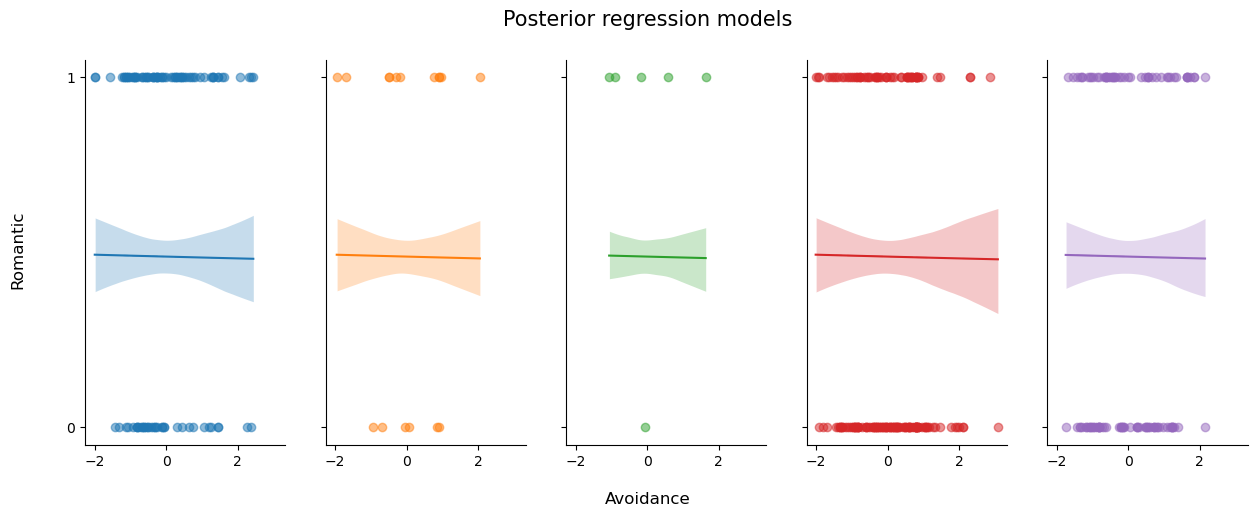

In [ ]:
plot_logit_regression(data=df_first5,
                      trace=complete_log_trace,
                      group_index=logit_index)